<a href="https://colab.research.google.com/github/PedroHPCintra/IA_025/blob/main/Final_project/Trabalho_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instalação de pacotes necessários

In [ ]:
!pip install efficientnet_pytorch
!pip install transformers
!pip install pytorch-lightning
!pip install sacrebleu
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=15baf21b675dc7e35e8c82358625b1ffc7c2b0a7362705bb1307596a1d54da28
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 14.7 MB/s 
     |████████████████████████████████| 596 kB 59.0 MB/s 
     |████████████████████████████████| 101 kB 10.9 MB/s 
     |████████████████████████████████| 6.6 MB 57.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simpl

#Import das bibliotecas

In [ ]:
import h5py, json
import numpy as np
import random
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
import os
import sentencepiece as spm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from pytorch_lightning.loggers import TensorBoardLogger

from efficientnet_pytorch import EfficientNet
from transformers import T5Tokenizer, T5ForConditionalGeneration
import pytorch_lightning as pl
import sacrebleu

from tqdm import tqdm

from google.colab import drive
# drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.cpu_count(), torch.cuda.get_device_name() if device == "cuda" else None

(2, 'Tesla P100-PCIE-16GB')

#Dataset MSCOCO

>Usando a versão reduzida com 23k dados nos primeiros testes

In [ ]:
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5

--2022-06-30 01:25:03--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289777 (283K) [application/json]
Saving to: ‘TEST_CAPTIONS_coco_5_cap_per_img.json’

TEST_CAPTIONS_coco_ 100%[===================>] 282.99K  --.-KB/s    in 0.002s  

2022-06-30 01:25:03 (156 MB/s) - ‘TEST_CAPTIONS_coco_5_cap_per_img.json’ saved [289777/289777]

--2022-06-30 01:25:03--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request se

In [ ]:
imgs = h5py.File('TRAIN_IMAGES_coco_5_cap_per_img.hdf5', 'r')
imgs.keys()

<KeysViewHDF5 ['images']>

###Mostrando alguns exemplos

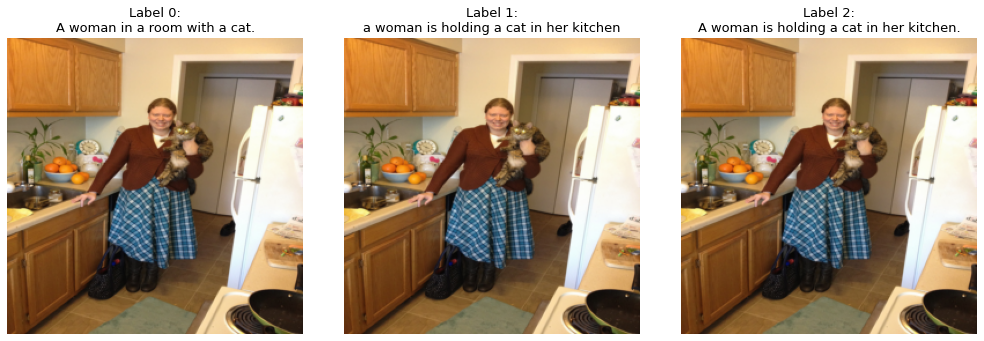

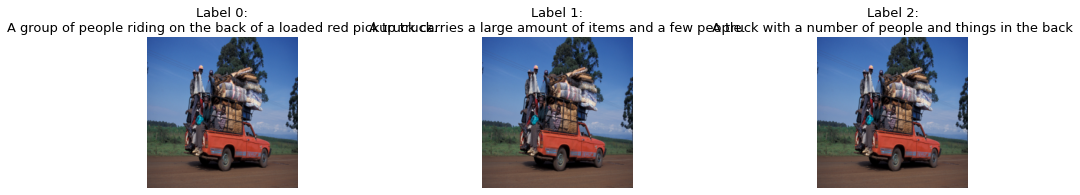

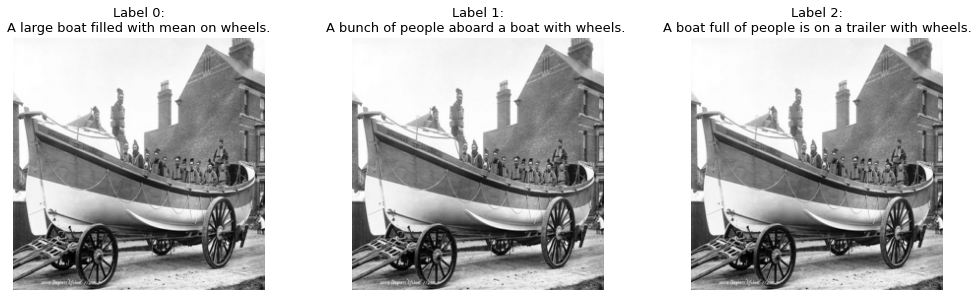

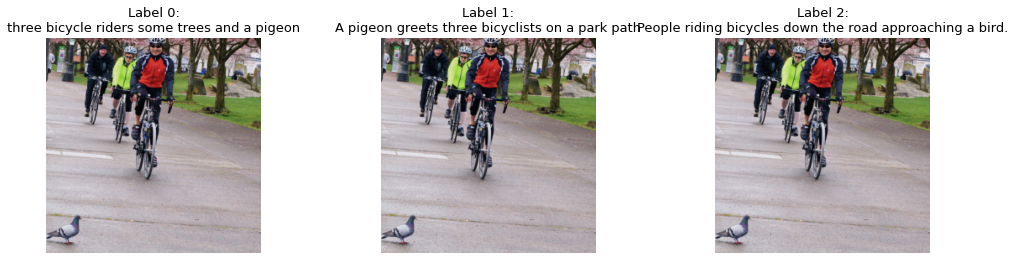

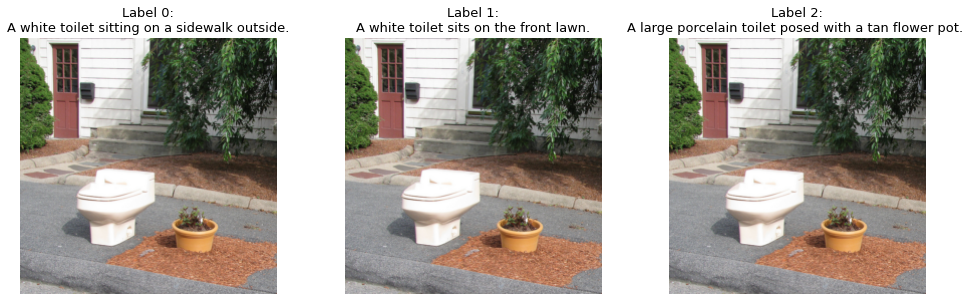

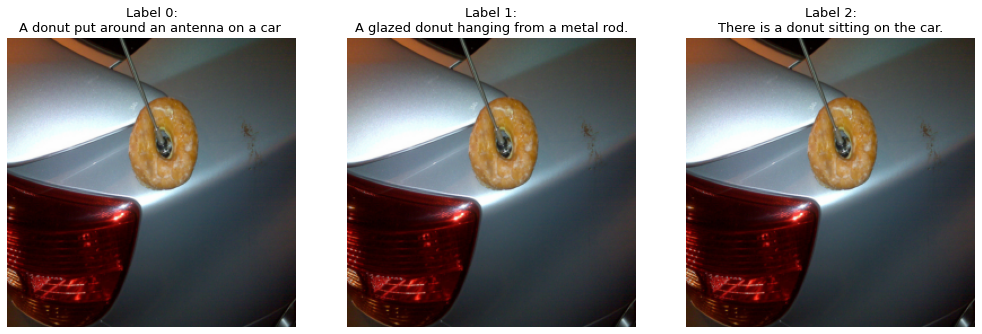

In [ ]:
imgs_new = imgs['images']
# print('Types in images'
# '\n')
# print(f'type: {imgs_new.dtype} {type(imgs_new)} {type(imgs_new[0])}\nshape: {imgs_new.shape}'
# '\n')
# print('Types in captions'
# '\n')
# print(f'type: {type(captions)}, {type(captions[0])} len: {len(captions)}, {len(captions[0])}'
# '\n')

for j in range(6):
  img = Image.fromarray(imgs_new[j].transpose(1,2,0))
  # display(img)
  with open('TRAIN_CAPTIONS_coco_5_cap_per_img.json') as json_file:
      captions = json.load(json_file)
  fig, ax = plt.subplots(1, 3, figsize=(14,6))
  for i in range(3):
    ax[i].imshow(img)
    ax[i].set_title(f'Label {i}:'
    '\n'
    f'{captions[j][i]}', fontsize = 13)
    ax[i].axis('off')

  fig.patch.set_alpha(0.5)
  plt.tight_layout()
  plt.show()

#Carregamento dos dados

In [ ]:
ENCODER = 'efficientnet-b0'
DECODER = 't5-small'
BATCH_SIZE = 32
NUM_WORKERS = 2

In [ ]:
#Para a normalização, usamos a sugerida neste github: https://github.com/lukemelas/EfficientNet-PyTorch/blob/master/README.md

transform = transforms.Compose([transforms.Lambda(lambda x: x * 2.0  - 1.0)])

tokenizer = T5Tokenizer.from_pretrained(DECODER)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
train_label = json.load(open("/content/TRAIN_CAPTIONS_coco_5_cap_per_img.json"))
val_label = json.load(open("/content/VAL_CAPTIONS_coco_5_cap_per_img.json"))
test_label = json.load(open("/content/TEST_CAPTIONS_coco_5_cap_per_img.json"))

train_img_path = "/content/TRAIN_IMAGES_coco_5_cap_per_img.hdf5"
train_label_path = "/content/TRAIN_CAPTIONS_coco_5_cap_per_img.json"
val_img_path = "/content/VAL_IMAGES_coco_5_cap_per_img.hdf5"
val_label_path = "/content/VAL_CAPTIONS_coco_5_cap_per_img.json"
test_img_path = "/content/TEST_IMAGES_coco_5_cap_per_img.hdf5"
test_label_path = "/content/TEST_CAPTIONS_coco_5_cap_per_img.json"

In [ ]:
class ImageCaptionDataset(Dataset):
    def __init__(self, path_imgs, path_labels, transform = None, label_max_length: int = 32):
        h5_file = h5py.File(path_imgs, 'r')
        self.images = h5_file['images']
        self.labels = np.array(path_labels)
        self.transform = transform
        self.tokenizer = tokenizer
        self.label_max_length = label_max_length

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label_idx = np.random.randint(0, 5)
        image, label = self.images[idx], self.labels[idx]
        image = np.transpose(image, (1, 2, 0)) 

        if self.transform is not None:
            image = self.transform(image)

        tokenized_label = self.tokenizer(label[label_idx],
                                           max_length=self.label_max_length,
                                           padding='max_length', truncation=True, 
                                           return_tensors='pt')
        label_token_ids = tokenized_label['input_ids'].squeeze(0)

        return image, label[label_idx], label_token_ids
    
    def test(self):
        fig, ax = plt.subplots(3, 1, figsize=(8, 16))
        samples = np.random.randint(0, high=self.__len__(), size=3)
        img1, text1, token1 = self.__getitem__(samples[0])
        img2, text2, token2 = self.__getitem__(samples[1])
        img3, text3, token3 = self.__getitem__(samples[2])

        img1 = np.transpose(img1, (1,2,0))
        img2 = np.transpose(img2, (1,2,0))
        img3 = np.transpose(img3, (1,2,0))

        ax[0].imshow(img1)
        ax[0].set_title(f'Label: {text1}')
        ax[0].set_xlabel(f'Token: {token1}')

        ax[1].imshow(img2)
        ax[1].set_title(f'Label: {text2}')
        ax[1].set_xlabel(f'Token: {token2}')

        ax[2].imshow(img3)
        ax[2].set_title(f'Label: {text3}')
        ax[2].set_xlabel(f'Token: {token3}')

        plt.tight_layout()
        plt.show()

###Criando o dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = ImageCaptionDataset(train_img_path, train_label, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True,  num_workers=NUM_WORKERS)

valset = ImageCaptionDataset(val_img_path, val_label, transform=transform)

valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

testset = ImageCaptionDataset(test_img_path, test_label, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

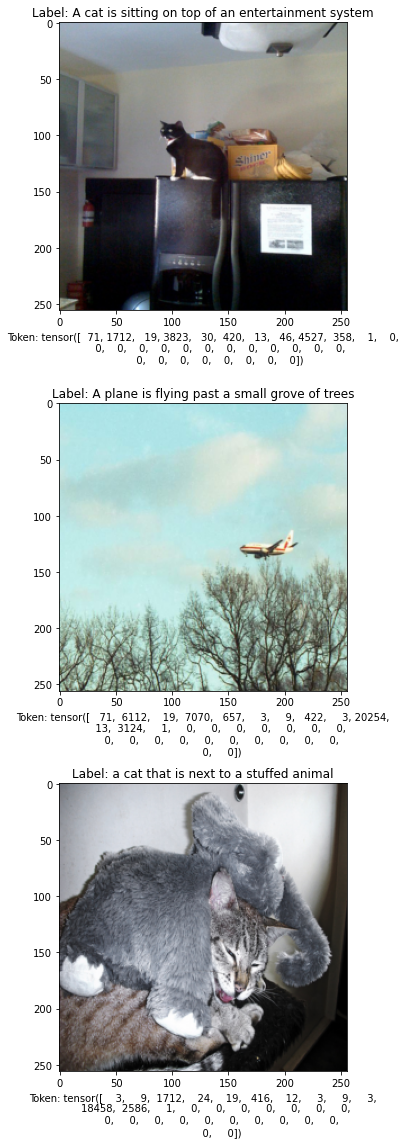

In [ ]:
trainset.test()

#Criando o modelo

In [ ]:
class EfficientT5(torch.nn.Module):
  def __init__(self):
        super(EfficientT5, self).__init__()

        #Encoder
        self.encoder = EfficientNet.from_pretrained('efficientnet-b0', advprop=True)
        # Para usar o encoder apenas como extrator de features
        for param in self.encoder.parameters():
            param.requires_grad = False

        #Decoder
        self.decoder = T5ForConditionalGeneration.from_pretrained('t5-small')
        
        #É preciso converter a saída do encoder em um formato de entrada aceito pelo decoder
        #Isso é feito usando uma camada convolcional 
        self.bridge = nn.Conv2d(in_channels=1280, out_channels=self.decoder.config.d_model, kernel_size=1)


  def forward(self, image, labels = None):
        #Extração das features
        features = self.encoder.extract_features(image)
        features = self.bridge(features)

        #Essa será a entrada para fazer o embedding
        to_generate_embed = features.reshape(features.shape[0], -1, self.decoder.config.d_model) #(Batch_size, img_encoded_size, decoder_input_size)

        if labels is not None:
          # O primeiro elemento retornado pelo decoder é a loss
          loss = self.decoder(inputs_embeds = to_generate_embed, labels = labels)[0]
          return loss

        else:
          # Gera os tokens
          predict_tokens = self.generate(to_generate_embed)
          return predict_tokens


  def generate(self, to_generate_embed):   #Função de geração dos tokens
    encoder_out = self.decoder.encoder(inputs_embeds = to_generate_embed)
    decoder_tokens = self.decoder.generate(encoder_outputs = encoder_out, max_length = 64)
    return decoder_tokens

In [ ]:
def train(model, dataloader, learning_rate, optimizer, epoch):
  

  model.train()

  train_batch = tqdm(dataloader, total=len(dataloader))
  actual_loss = 0.0

  for images, _, caption_tokens  in train_batch:
    inputs = images.to(device)
    labels = caption_tokens.to(device)
    optimizer.zero_grad()
    loss = model(inputs, labels)
    loss.backward()
    optimizer.step()
    actual_loss += loss.item()
  actual_loss = actual_loss/len(train_batch)

  return actual_loss

In [ ]:
def val(model, device, dataloader, epoch):
  
    model.eval()

    val_batch = tqdm(dataloader, total=len(dataloader))
    val_loss = 0.0
    min_error = float("inf")

    for images, _, labels_tokens_ids in val_batch:
      inputs = images.to(device)
      labels = labels_tokens_ids.to(device)
      loss = model(inputs, labels)
      val_loss += loss.item()
    val_loss = val_loss/len(val_batch)  
    return val_loss

In [ ]:
model = EfficientT5()
model = model.to(device)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
 
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    train_loss = train(model, trainloader, learning_rate, optimizer, epoch)
    train_loss_history.append(train_loss)

    val_loss = val(model, device, valloader, epoch)
    val_loss_history.append(val_loss)
 
    print('Epoch %d - Train Loss %.5f - Validation Loss %.5f' 
          %(epoch, train_loss, val_loss))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b0-b64d5a18.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

100%|██████████| 33/33 [00:03<00:00,  9.39it/s]


Epoch 0 - Train Loss 3.34102 - Validation Loss 1.73466


100%|██████████| 33/33 [00:04<00:00,  8.24it/s]


Epoch 1 - Train Loss 1.66908 - Validation Loss 1.46324


100%|██████████| 33/33 [00:03<00:00,  9.68it/s]


Epoch 2 - Train Loss 1.52839 - Validation Loss 1.42230


100%|██████████| 33/33 [00:03<00:00,  9.70it/s]


Epoch 3 - Train Loss 1.47801 - Validation Loss 1.39123


100%|██████████| 33/33 [00:03<00:00,  9.63it/s]


Epoch 4 - Train Loss 1.44348 - Validation Loss 1.34015


100%|██████████| 33/33 [00:03<00:00,  9.66it/s]


Epoch 5 - Train Loss 1.41710 - Validation Loss 1.32803


100%|██████████| 33/33 [00:03<00:00,  9.64it/s]


Epoch 6 - Train Loss 1.40328 - Validation Loss 1.31494


100%|██████████| 33/33 [00:03<00:00,  9.70it/s]


Epoch 7 - Train Loss 1.37755 - Validation Loss 1.29943


100%|██████████| 33/33 [00:03<00:00,  9.71it/s]


Epoch 8 - Train Loss 1.36577 - Validation Loss 1.26195


100%|██████████| 33/33 [00:03<00:00,  9.82it/s]

Epoch 9 - Train Loss 1.35665 - Validation Loss 1.27140


#Teste

100%|██████████| 33/33 [00:27<00:00,  1.21it/s]


BLEU 1-gram 0.00 - BLEU 4-gram 0.00 - BLEU Score 0.00


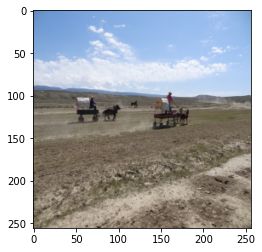

Label: A couple of people riding horse drawn carriage through the desert.
Predicted: A cat sitting on a chair with a teddy bear.


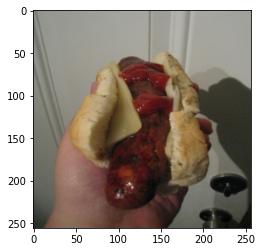

Label: a sausage sandwich in a bun with ketchup on top 
Predicted: A large plane flying over a city street.


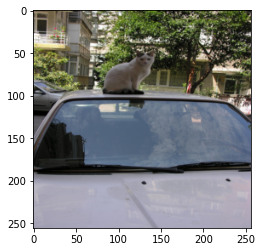

Label: A cat is perched on top of a parked car.
Predicted: A man is laying on a horse in a field.


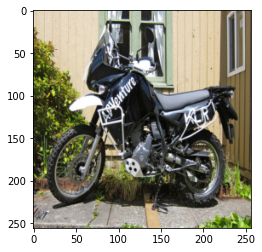

Label: A motorcycle sits beside a wooden building with windows.
Predicted: A cat sitting on a chair in a chair.


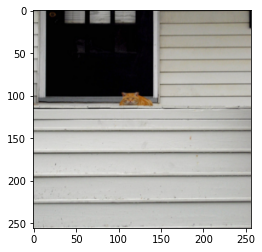

Label: An orange cat sitting in front of a door to a house.
Predicted: A cat sitting on a chair with a hat.


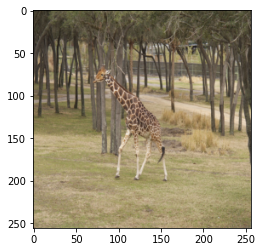

Label: A giraffe standing in a ground with trees and scanty grass.
Predicted: A cat sitting on a chair with a hat.


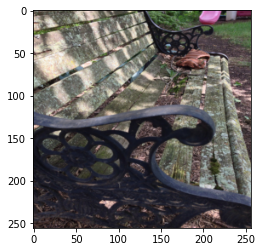

Label: A bench is shown in the dirt by the house.
Predicted: A man is laying on a horse in a field.


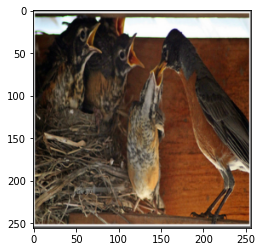

Label: A mother bird feeds her baby birds by the nest.
Predicted: A cat sitting on a chair in a chair.


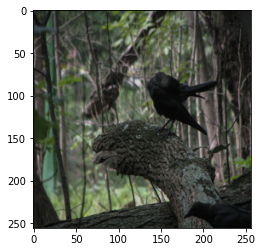

Label: two blackbirds mating on a large branch with a forest in the  background
Predicted: A man is sitting on a bench with a dog.


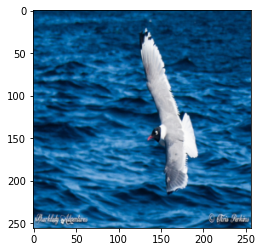

Label: A white and gray bird soaring over the blue ocean.
Predicted: A man is laying on a bed with a dog.


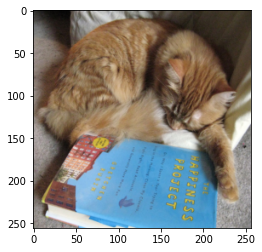

Label: A cat sleeping on a pillow next to a book.
Predicted: A cat sitting on a chair with a hat.


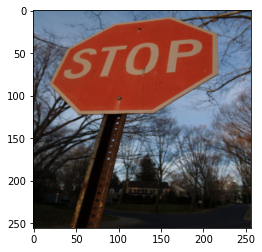

Label: a stop sign on the side of a street 
Predicted: A cat sitting on a chair in a chair.


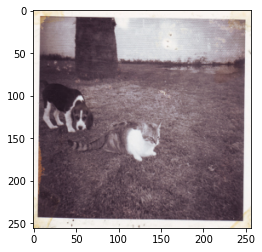

Label: A curious dog sniffs near a cat that's sitting on the grass.
Predicted: A man is laying on a bed with a dog.


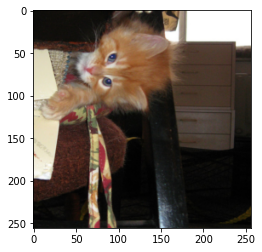

Label: a close up of a cat near a couch on the ground
Predicted: A cat sitting on a chair with a hat.


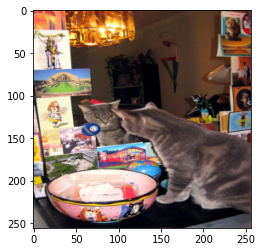

Label: A cat standing next to a multi-colored bowl stares at himself in the mirror.
Predicted: A cat sitting on a chair with a hat.


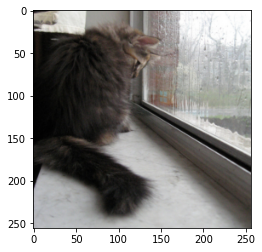

Label: a close up of a cat on a window sill looking out the window
Predicted: A cat sitting on a chair with a hat.


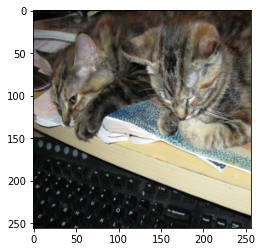

Label: Two cats that are laying down on a desk.
Predicted: A man is laying on a bed with a dog.


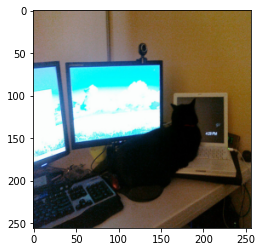

Label: A cat that is sitting on top of a laptop.
Predicted: A man is laying on a bed with a dog.


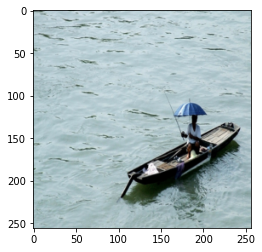

Label: A man riding on the back of a boat floating in water.
Predicted: A cat sitting on a chair in a chair.


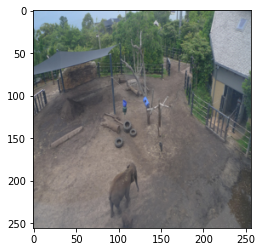

Label: A small elephant stands alone in an enclosure.
Predicted: A man is standing in a car with a dog.


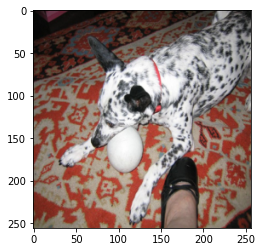

Label: A dalmatian dog laying on the floor with a ball.
Predicted: A cat sitting on a couch in a chair.


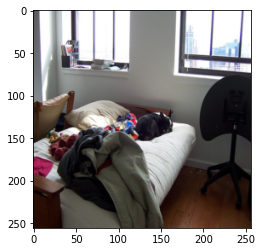

Label: A dog sleeping on the corner of an untidy bed.
Predicted: A cat sitting on a chair with a hat.


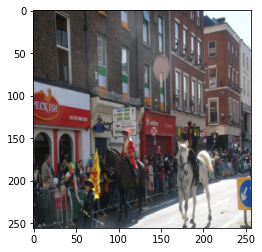

Label: A man dressed in red riding a horse through town
Predicted: A cat sitting on a chair with a hat.


In [ ]:
model.eval()

test_batch = tqdm(testloader, total=len(testloader))

predicted_labels = []
target_labels = []
bleu_list = []

bleu_1 = 0
bleu_4 = 0
bleu_score = 0

for images, labels, tokens in test_batch:
    inputs = images.to(device)
    tokens = tokens.to(device)

    predicted_token_ids = model(inputs)

    predicted_labels_batch = [tokenizer.decode(token, skip_special_tokens=True) for token in predicted_token_ids]

    predicted_labels += predicted_labels_batch
    target_labels += labels 

for predicted, target in zip(predicted_labels, target_labels):
  if predicted == '' or ' ':
    pass
  else:
    bleu = sacrebleu.corpus_bleu(predicted, target)
    bleu_1 += bleu.precisions[0]
    bleu_4 += bleu.precisions[3]
    bleu_score += bleu.score



print('BLEU 1-gram %.2f - BLEU 4-gram %.2f - BLEU Score %.2f' % 
      (bleu_1/len(predicted_labels), bleu_4/len(predicted_labels), bleu_score/len(predicted_labels)))

for image, label, predicted in zip(images, labels, predicted_labels):
  plt.imshow(np.transpose(image, (1,2,0)))
  plt.show()
  print('Label:', label)
  print('Predicted:', predicted)

